In [1]:
import os
import glob
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from monai.data import Dataset, DataLoader
import pandas as pd

## Verileri Yükleme ve Uygun Formata Dönüştürme

In [2]:
DATA_DIR = r"C:\Users\omer_\Documents\GitHub\ytustats\standard_u-net\Brain_Stroke_CT_Dataset"

TRAIN_CLASSES = ["Bleeding", "Ischemia", "Normal"]
class_map = {name: i for i, name in enumerate(TRAIN_CLASSES)}
print(f"Sınıflar ve etiketleri: {class_map}")

IMAGE_TYPE_FOLDER = 'DICOM' 
FILE_EXTENSION = '.dcm'

Sınıflar ve etiketleri: {'Bleeding': 0, 'Ischemia': 1, 'Normal': 2}


In [3]:
# --- 2. EĞİTİM/DOĞRULAMA/TEST VERİLERİNİ TOPLAMA ---

image_files = []
labels = []

print("\nEğitim/Doğrulama/Test setleri için dosyalar taranıyor...")
for class_name in TRAIN_CLASSES:
    # YENİ YOL YAPISI: .../Brain_Stroke_CT_Dataset/Bleeding/PNG/
    class_dir = os.path.join(DATA_DIR, class_name, IMAGE_TYPE_FOLDER)
    
    if not os.path.isdir(class_dir):
        print(f"UYARI: '{class_dir}' yolu bulunamadı, atlanıyor.")
        continue

    # Belirtilen yoldaki tüm dosyaları bul
    files_in_class = glob.glob(os.path.join(class_dir, f'*{FILE_EXTENSION}'))
    image_files.extend(files_in_class)
    # Her dosya için ilgili etiket numarasını ekle
    labels.extend([class_map[class_name]] * len(files_in_class))

print(f"Toplam {len(image_files)} adet görüntü dosyası bulundu.")
for i, name in enumerate(TRAIN_CLASSES):
    print(f"- {name}: {labels.count(i)} adet")



Eğitim/Doğrulama/Test setleri için dosyalar taranıyor...
Toplam 6650 adet görüntü dosyası bulundu.
- Bleeding: 1093 adet
- Ischemia: 1130 adet
- Normal: 4427 adet


In [4]:
# --- 3. VERİYİ AYIRMA (TRAIN/VALIDATION/TEST - 70/15/15) ---
X_train, X_temp, y_train, y_temp = train_test_split(
    image_files, labels, test_size=0.30, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("\nVeri seti ayırma işlemi tamamlandı:")
print(f"Eğitim Seti (Train):   {len(X_train)} örnek")
print(f"Doğrulama Seti (Val):  {len(X_val)} örnek")
print(f"Test Seti (Bizim):     {len(X_test)} örnek") # Kendi oluşturduğumuz test seti


train_data = [{"image": img_path, "label": label} for img_path, label in zip(X_train, y_train)]
val_data = [{"image": img_path, "label": label} for img_path, label in zip(X_val, y_val)]
test_data = [{"image": img_path, "label": label} for img_path, label in zip(X_test, y_test)]


Veri seti ayırma işlemi tamamlandı:
Eğitim Seti (Train):   4655 örnek
Doğrulama Seti (Val):  997 örnek
Test Seti (Bizim):     998 örnek


In [5]:
# --- 4. EXTERNAL TEST IMPORT ETME
external_test_data = []
external_test_dir = os.path.join(DATA_DIR, "External_Test", IMAGE_TYPE_FOLDER)
if os.path.isdir(external_test_dir):
    external_test_files = glob.glob(os.path.join(external_test_dir, f'*{FILE_EXTENSION}'))
    for img_path in external_test_files:
        # Dış test seti için etiket bilgisi yok, sadece görüntü yolu
        external_test_data.append({"image": img_path})

    print(f"\nDış test setinden {len(external_test_data)} adet görüntü dosyası bulundu.")
else:
    print("\nDış test seti bulunamadı veya klasör mevcut değil.")
    


Dış test setinden 200 adet görüntü dosyası bulundu.


In [6]:
# MONAI ÖN İŞLEME ZİNCİRİ(TRANSFORMS)

from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityd,
    Resized,
    RandRotated,
    RandFlipd,
    ToTensord
)
train_transforms = Compose([
    LoadImaged(keys="image", image_only=True),
    EnsureChannelFirstd(keys="image"),
    ScaleIntensityd(keys="image"),
    Resized(keys="image", spatial_size=(256, 256)),
    RandRotated(keys="image", range_x=15, prob=0.5, keep_size=True),
    RandFlipd(keys="image", spatial_axis=0, prob=0.5),
    ToTensord(keys=["image", "label"])
])

val_transforms = Compose([
    LoadImaged(keys="image", image_only=True),
    EnsureChannelFirstd(keys="image"),
    ScaleIntensityd(keys="image"),
    Resized(keys="image", spatial_size=(256, 256)),
    ToTensord(keys=["image", "label"])
])

In [7]:
# --- 6. MONAI DATASET VE DATALOADER OLUŞTURMA ---
train_dataset = Dataset(data=train_data, transform=train_transforms)
val_dataset = Dataset(data=val_data, transform=val_transforms)
test_dataset = Dataset(data=test_data, transform=val_transforms)
external_test_dataset = Dataset(data=external_test_data, transform=val_transforms)

# DataLoader'lar
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)
external_test_loader = DataLoader(external_test_dataset, batch_size=16, shuffle=False, num_workers=2)

print("\nTüm DataLoader'lar başarıyla oluşturuldu.")


Tüm DataLoader'lar başarıyla oluşturuldu.



Eğitim yükleyicisi kontrolü:
Görüntülerin boyutu: torch.Size([16, 1, 256, 256])
Etiketlerin boyutu: torch.Size([16])


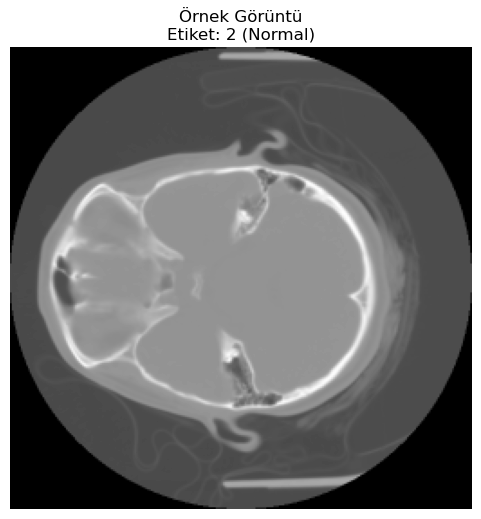

In [9]:
import matplotlib.pyplot as plt

if len(train_loader) > 0:
    check_batch = next(iter(train_loader))
    images, labels = check_batch["image"], check_batch["label"]
    print(f"\nEğitim yükleyicisi kontrolü:")
    print(f"Görüntülerin boyutu: {images.shape}")
    print(f"Etiketlerin boyutu: {labels.shape}")

    plt.figure("Veri Hattı Kontrolü", figsize=(6, 6))
    plt.imshow(images[0, 0, :, :], cmap="gray")
    plt.title(f"Örnek Görüntü\nEtiket: {labels[0].item()} ({TRAIN_CLASSES[labels[0].item()]})")
    plt.axis('off')
    plt.show()
else:
    print("\nUYARI: Eğitim yükleyicisi boş, kontrol adımı atlandı. Dosya yollarını kontrol edin.")

## Standart U-Net Modeli (MONAI)

In [8]:
import torch
import torch.nn as nn
from torch.optim import Adam
from monai.networks.nets import UNet
from monai.losses import FocalLoss, DiceLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nKullanılan cihaz: {device}")


Kullanılan cihaz: cuda


In [9]:
# --- STANDART MONAI U-Net AĞI OLUŞTURMA ---
# U-Net'e bir sınıflandırma katmanı ekleyelim

class ClassificationUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        # BU SATIR ÇOK ÖNEMLİ! PyTorch modelinin temelini kurar.
        super().__init__()
        
        # BU SATIR, hatanın bahsettiği 'unet_base' parçasını oluşturur.
        self.unet_base = UNet(
            spatial_dims=2,
            in_channels=in_channels,
            out_channels=128, 
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(128, out_channels)

    def forward(self, x):
        features = self.unet_base(x)
        pooled_features = self.pool(features)
        pooled_features = torch.flatten(pooled_features, 1)
        output = self.classifier(pooled_features)
        return output


model = ClassificationUNet(in_channels=1, out_channels=3).to(device)

print(f"\nModel başarıyla oluşturuldu.")
print(f"Modelin parametre sayısı: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# --- KAYIP FONKSİYONU VE OPTİMİZASYON ---

loss_function = FocalLoss(to_onehot_y=True)

learning_rate = 1e-4
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

print(f"\nKayıp fonksiyonu: {loss_function.__class__.__name__}")
print(f"Optimizasyon algoritması: {optimizer.__class__.__name__} (LR: {learning_rate})")



Model başarıyla oluşturuldu.
Modelin parametre sayısı: 1,809,508

Kayıp fonksiyonu: FocalLoss
Optimizasyon algoritması: Adam (LR: 0.0001)


c:\Users\omer_\anaconda3\envs\tdl\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

max_epochs = 20
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
val_loss_values = []
metric_values = []

In [ ]:
for epoch in range(max_epochs):
    print("-" * 20)
    print(f"Epoch {epoch + 1}/{max_epochs}")

    model.train()
    epoch_loss = 0.0
    step = 0

    for batch_data in tqdm(train_loader, desc="Eğitim"):
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1} için ortalama eğitim kaybı: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        
        val_epoch_loss = 0
        val_step = 0
        
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for val_batch in tqdm(val_loader, desc="Doğrulama"):
                val_step += 1
                val_images, val_labels = val_batch["image"].to(device), val_batch["label"].to(device)
                val_outputs = model(val_images)
                
                loss = loss_function(val_outputs, val_labels)
                val_epoch_loss += loss.item()

                predicted_classes = torch.argmax(val_outputs, dim=1)
                correct_predictions += (predicted_classes == val_labels).sum().item()
                total_samples += val_labels.size(0)
            
            mean_val_accuracy = correct_predictions / total_samples
            metric_values.append(mean_val_accuracy)
            
            val_epoch_loss /= val_step
            val_loss_values.append(val_epoch_loss)

            if mean_val_accuracy > best_metric:
                best_metric = mean_val_accuracy
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_resnet18_model.pth")
                print("En iyi metrik kaydedildi!")

            print(
                f"Epoch {epoch + 1} Ortalama Doğrulama Kaybı: {val_epoch_loss:.4f} "
                f"| Doğruluk: {mean_val_accuracy:.4f}"
            )
            print(
                f"En iyi metrik şu ana kadar: {best_metric:.4f} "
                f"(epoch {best_metric_epoch})")

    scheduler.step(val_epoch_loss)


print(f"\nEğitim tamamlandı. En iyi model 'best_resnet18_model.pth' olarak kaydedildi.")

--------------------
Epoch 1/50


Eğitim: 100%|██████████| 291/291 [01:30<00:00,  3.21it/s]


Epoch 1 için ortalama eğitim kaybı: 0.1314


Doğrulama: 100%|██████████| 63/63 [00:27<00:00,  2.29it/s]


En iyi metrik kaydedildi!
Epoch 1 Ortalama Doğrulama Kaybı: 0.1275 | Doğruluk: 0.6660
En iyi metrik şu ana kadar: 0.6660 (epoch 1)
--------------------
Epoch 2/50


Eğitim: 100%|██████████| 291/291 [01:25<00:00,  3.39it/s]


Epoch 2 için ortalama eğitim kaybı: 0.1242


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 2 Ortalama Doğrulama Kaybı: 0.1180 | Doğruluk: 0.6660
En iyi metrik şu ana kadar: 0.6660 (epoch 1)
--------------------
Epoch 3/50


Eğitim: 100%|██████████| 291/291 [01:29<00:00,  3.24it/s]


Epoch 3 için ortalama eğitim kaybı: 0.1184


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.60it/s]


En iyi metrik kaydedildi!
Epoch 3 Ortalama Doğrulama Kaybı: 0.1104 | Doğruluk: 0.7111
En iyi metrik şu ana kadar: 0.7111 (epoch 3)
--------------------
Epoch 4/50


Eğitim: 100%|██████████| 291/291 [01:22<00:00,  3.53it/s]


Epoch 4 için ortalama eğitim kaybı: 0.1164


Doğrulama: 100%|██████████| 63/63 [00:23<00:00,  2.74it/s]


En iyi metrik kaydedildi!
Epoch 4 Ortalama Doğrulama Kaybı: 0.1098 | Doğruluk: 0.7372
En iyi metrik şu ana kadar: 0.7372 (epoch 4)
--------------------
Epoch 5/50


Eğitim: 100%|██████████| 291/291 [01:17<00:00,  3.73it/s]


Epoch 5 için ortalama eğitim kaybı: 0.1124


Doğrulama: 100%|██████████| 63/63 [00:22<00:00,  2.74it/s]


En iyi metrik kaydedildi!
Epoch 5 Ortalama Doğrulama Kaybı: 0.1071 | Doğruluk: 0.7452
En iyi metrik şu ana kadar: 0.7452 (epoch 5)
--------------------
Epoch 6/50


Eğitim: 100%|██████████| 291/291 [01:18<00:00,  3.73it/s]


Epoch 6 için ortalama eğitim kaybı: 0.1105


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch 6 Ortalama Doğrulama Kaybı: 0.1004 | Doğruluk: 0.7422
En iyi metrik şu ana kadar: 0.7452 (epoch 5)
--------------------
Epoch 7/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.66it/s]


Epoch 7 için ortalama eğitim kaybı: 0.1082


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 7 Ortalama Doğrulama Kaybı: 0.1046 | Doğruluk: 0.7262
En iyi metrik şu ana kadar: 0.7452 (epoch 5)
--------------------
Epoch 8/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.68it/s]


Epoch 8 için ortalama eğitim kaybı: 0.1062


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 8 Ortalama Doğrulama Kaybı: 0.1006 | Doğruluk: 0.7352
En iyi metrik şu ana kadar: 0.7452 (epoch 5)
--------------------
Epoch 9/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.68it/s]


Epoch 9 için ortalama eğitim kaybı: 0.1059


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.56it/s]


En iyi metrik kaydedildi!
Epoch 9 Ortalama Doğrulama Kaybı: 0.0946 | Doğruluk: 0.7573
En iyi metrik şu ana kadar: 0.7573 (epoch 9)
--------------------
Epoch 10/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.68it/s]


Epoch 10 için ortalama eğitim kaybı: 0.1039


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


En iyi metrik kaydedildi!
Epoch 10 Ortalama Doğrulama Kaybı: 0.0920 | Doğruluk: 0.7693
En iyi metrik şu ana kadar: 0.7693 (epoch 10)
--------------------
Epoch 11/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.65it/s]


Epoch 11 için ortalama eğitim kaybı: 0.1037


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 11 Ortalama Doğrulama Kaybı: 0.0914 | Doğruluk: 0.7452
En iyi metrik şu ana kadar: 0.7693 (epoch 10)
--------------------
Epoch 12/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.67it/s]


Epoch 12 için ortalama eğitim kaybı: 0.1000


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


En iyi metrik kaydedildi!
Epoch 12 Ortalama Doğrulama Kaybı: 0.0877 | Doğruluk: 0.7783
En iyi metrik şu ana kadar: 0.7783 (epoch 12)
--------------------
Epoch 13/50


Eğitim: 100%|██████████| 291/291 [01:18<00:00,  3.69it/s]


Epoch 13 için ortalama eğitim kaybı: 0.0990


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch 13 Ortalama Doğrulama Kaybı: 0.0937 | Doğruluk: 0.7543
En iyi metrik şu ana kadar: 0.7783 (epoch 12)
--------------------
Epoch 14/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.65it/s]


Epoch 14 için ortalama eğitim kaybı: 0.0973


Doğrulama: 100%|██████████| 63/63 [00:26<00:00,  2.34it/s]


Epoch 14 Ortalama Doğrulama Kaybı: 0.0855 | Doğruluk: 0.7703
En iyi metrik şu ana kadar: 0.7783 (epoch 12)
--------------------
Epoch 15/50


Eğitim: 100%|██████████| 291/291 [01:21<00:00,  3.59it/s]


Epoch 15 için ortalama eğitim kaybı: 0.0968


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 15 Ortalama Doğrulama Kaybı: 0.0859 | Doğruluk: 0.7643
En iyi metrik şu ana kadar: 0.7783 (epoch 12)
--------------------
Epoch 16/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.68it/s]


Epoch 16 için ortalama eğitim kaybı: 0.0946


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.56it/s]


En iyi metrik kaydedildi!
Epoch 16 Ortalama Doğrulama Kaybı: 0.0856 | Doğruluk: 0.7904
En iyi metrik şu ana kadar: 0.7904 (epoch 16)
--------------------
Epoch 17/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.67it/s]


Epoch 17 için ortalama eğitim kaybı: 0.0931


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 17 Ortalama Doğrulama Kaybı: 0.0863 | Doğruluk: 0.7743
En iyi metrik şu ana kadar: 0.7904 (epoch 16)
--------------------
Epoch 18/50


Eğitim: 100%|██████████| 291/291 [01:20<00:00,  3.63it/s]


Epoch 18 için ortalama eğitim kaybı: 0.0910


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch 18 Ortalama Doğrulama Kaybı: 0.0885 | Doğruluk: 0.7733
En iyi metrik şu ana kadar: 0.7904 (epoch 16)
--------------------
Epoch 19/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.68it/s]


Epoch 19 için ortalama eğitim kaybı: 0.0863


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


En iyi metrik kaydedildi!
Epoch 19 Ortalama Doğrulama Kaybı: 0.0783 | Doğruluk: 0.8124
En iyi metrik şu ana kadar: 0.8124 (epoch 19)
--------------------
Epoch 20/50


Eğitim: 100%|██████████| 291/291 [01:18<00:00,  3.72it/s]


Epoch 20 için ortalama eğitim kaybı: 0.0845


Doğrulama: 100%|██████████| 63/63 [00:23<00:00,  2.71it/s]


Epoch 20 Ortalama Doğrulama Kaybı: 0.0776 | Doğruluk: 0.8034
En iyi metrik şu ana kadar: 0.8124 (epoch 19)
--------------------
Epoch 21/50


Eğitim: 100%|██████████| 291/291 [01:18<00:00,  3.73it/s]


Epoch 21 için ortalama eğitim kaybı: 0.0833


Doğrulama: 100%|██████████| 63/63 [00:23<00:00,  2.73it/s]


En iyi metrik kaydedildi!
Epoch 21 Ortalama Doğrulama Kaybı: 0.0770 | Doğruluk: 0.8134
En iyi metrik şu ana kadar: 0.8134 (epoch 21)
--------------------
Epoch 22/50


Eğitim: 100%|██████████| 291/291 [01:18<00:00,  3.72it/s]


Epoch 22 için ortalama eğitim kaybı: 0.0819


Doğrulama: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch 22 Ortalama Doğrulama Kaybı: 0.0769 | Doğruluk: 0.8104
En iyi metrik şu ana kadar: 0.8134 (epoch 21)
--------------------
Epoch 23/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.67it/s]


Epoch 23 için ortalama eğitim kaybı: 0.0818


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.56it/s]


En iyi metrik kaydedildi!
Epoch 23 Ortalama Doğrulama Kaybı: 0.0760 | Doğruluk: 0.8164
En iyi metrik şu ana kadar: 0.8164 (epoch 23)
--------------------
Epoch 24/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.68it/s]


Epoch 24 için ortalama eğitim kaybı: 0.0792


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 24 Ortalama Doğrulama Kaybı: 0.0754 | Doğruluk: 0.8144
En iyi metrik şu ana kadar: 0.8164 (epoch 23)
--------------------
Epoch 25/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.64it/s]


Epoch 25 için ortalama eğitim kaybı: 0.0799


Doğrulama: 100%|██████████| 63/63 [00:26<00:00,  2.34it/s]


Epoch 25 Ortalama Doğrulama Kaybı: 0.0750 | Doğruluk: 0.8154
En iyi metrik şu ana kadar: 0.8164 (epoch 23)
--------------------
Epoch 26/50


Eğitim: 100%|██████████| 291/291 [01:20<00:00,  3.61it/s]


Epoch 26 için ortalama eğitim kaybı: 0.0788


Doğrulama: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


En iyi metrik kaydedildi!
Epoch 26 Ortalama Doğrulama Kaybı: 0.0740 | Doğruluk: 0.8195
En iyi metrik şu ana kadar: 0.8195 (epoch 26)
--------------------
Epoch 27/50


Eğitim: 100%|██████████| 291/291 [01:21<00:00,  3.57it/s]


Epoch 27 için ortalama eğitim kaybı: 0.0779


Doğrulama: 100%|██████████| 63/63 [00:26<00:00,  2.39it/s]


Epoch 27 Ortalama Doğrulama Kaybı: 0.0741 | Doğruluk: 0.8185
En iyi metrik şu ana kadar: 0.8195 (epoch 26)
--------------------
Epoch 28/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.66it/s]


Epoch 28 için ortalama eğitim kaybı: 0.0781


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


En iyi metrik kaydedildi!
Epoch 28 Ortalama Doğrulama Kaybı: 0.0744 | Doğruluk: 0.8225
En iyi metrik şu ana kadar: 0.8225 (epoch 28)
--------------------
Epoch 29/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.68it/s]


Epoch 29 için ortalama eğitim kaybı: 0.0781


Doğrulama: 100%|██████████| 63/63 [00:38<00:00,  1.65it/s]


En iyi metrik kaydedildi!
Epoch 29 Ortalama Doğrulama Kaybı: 0.0728 | Doğruluk: 0.8295
En iyi metrik şu ana kadar: 0.8295 (epoch 29)
--------------------
Epoch 30/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.65it/s]


Epoch 30 için ortalama eğitim kaybı: 0.0759


Doğrulama: 100%|██████████| 63/63 [00:23<00:00,  2.73it/s]


Epoch 30 Ortalama Doğrulama Kaybı: 0.0727 | Doğruluk: 0.8154
En iyi metrik şu ana kadar: 0.8295 (epoch 29)
--------------------
Epoch 31/50


Eğitim: 100%|██████████| 291/291 [01:18<00:00,  3.73it/s]


Epoch 31 için ortalama eğitim kaybı: 0.0780


Doğrulama: 100%|██████████| 63/63 [00:23<00:00,  2.73it/s]


En iyi metrik kaydedildi!
Epoch 31 Ortalama Doğrulama Kaybı: 0.0726 | Doğruluk: 0.8335
En iyi metrik şu ana kadar: 0.8335 (epoch 31)
--------------------
Epoch 32/50


Eğitim: 100%|██████████| 291/291 [01:18<00:00,  3.73it/s]


Epoch 32 için ortalama eğitim kaybı: 0.0769


Doğrulama: 100%|██████████| 63/63 [00:23<00:00,  2.73it/s]


Epoch 32 Ortalama Doğrulama Kaybı: 0.0736 | Doğruluk: 0.8164
En iyi metrik şu ana kadar: 0.8335 (epoch 31)
--------------------
Epoch 33/50


Eğitim: 100%|██████████| 291/291 [01:18<00:00,  3.69it/s]


Epoch 33 için ortalama eğitim kaybı: 0.0767


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 33 Ortalama Doğrulama Kaybı: 0.0724 | Doğruluk: 0.8185
En iyi metrik şu ana kadar: 0.8335 (epoch 31)
--------------------
Epoch 34/50


Eğitim: 100%|██████████| 291/291 [01:20<00:00,  3.64it/s]


Epoch 34 için ortalama eğitim kaybı: 0.0768


Doğrulama: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch 34 Ortalama Doğrulama Kaybı: 0.0713 | Doğruluk: 0.8235
En iyi metrik şu ana kadar: 0.8335 (epoch 31)
--------------------
Epoch 35/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.68it/s]


Epoch 35 için ortalama eğitim kaybı: 0.0752


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch 35 Ortalama Doğrulama Kaybı: 0.0722 | Doğruluk: 0.8285
En iyi metrik şu ana kadar: 0.8335 (epoch 31)
--------------------
Epoch 36/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.65it/s]


Epoch 36 için ortalama eğitim kaybı: 0.0759


Doğrulama: 100%|██████████| 63/63 [00:27<00:00,  2.33it/s]


Epoch 36 Ortalama Doğrulama Kaybı: 0.0706 | Doğruluk: 0.8315
En iyi metrik şu ana kadar: 0.8335 (epoch 31)
--------------------
Epoch 37/50


Eğitim: 100%|██████████| 291/291 [01:21<00:00,  3.59it/s]


Epoch 37 için ortalama eğitim kaybı: 0.0756


Doğrulama: 100%|██████████| 63/63 [00:26<00:00,  2.36it/s]


Epoch 37 Ortalama Doğrulama Kaybı: 0.0720 | Doğruluk: 0.8225
En iyi metrik şu ana kadar: 0.8335 (epoch 31)
--------------------
Epoch 38/50


Eğitim: 100%|██████████| 291/291 [01:18<00:00,  3.69it/s]


Epoch 38 için ortalama eğitim kaybı: 0.0743


Doğrulama: 100%|██████████| 63/63 [00:26<00:00,  2.34it/s]


Epoch 38 Ortalama Doğrulama Kaybı: 0.0704 | Doğruluk: 0.8275
En iyi metrik şu ana kadar: 0.8335 (epoch 31)
--------------------
Epoch 39/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.64it/s]


Epoch 39 için ortalama eğitim kaybı: 0.0749


Doğrulama: 100%|██████████| 63/63 [00:26<00:00,  2.34it/s]


Epoch 39 Ortalama Doğrulama Kaybı: 0.0706 | Doğruluk: 0.8295
En iyi metrik şu ana kadar: 0.8335 (epoch 31)
--------------------
Epoch 40/50


Eğitim: 100%|██████████| 291/291 [01:20<00:00,  3.61it/s]


Epoch 40 için ortalama eğitim kaybı: 0.0747


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


En iyi metrik kaydedildi!
Epoch 40 Ortalama Doğrulama Kaybı: 0.0696 | Doğruluk: 0.8385
En iyi metrik şu ana kadar: 0.8385 (epoch 40)
--------------------
Epoch 41/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.68it/s]


Epoch 41 için ortalama eğitim kaybı: 0.0747


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 41 Ortalama Doğrulama Kaybı: 0.0697 | Doğruluk: 0.8335
En iyi metrik şu ana kadar: 0.8385 (epoch 40)
--------------------
Epoch 42/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.67it/s]


Epoch 42 için ortalama eğitim kaybı: 0.0745


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch 42 Ortalama Doğrulama Kaybı: 0.0686 | Doğruluk: 0.8235
En iyi metrik şu ana kadar: 0.8385 (epoch 40)
--------------------
Epoch 43/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.64it/s]


Epoch 43 için ortalama eğitim kaybı: 0.0736


Doğrulama: 100%|██████████| 63/63 [00:26<00:00,  2.36it/s]


En iyi metrik kaydedildi!
Epoch 43 Ortalama Doğrulama Kaybı: 0.0689 | Doğruluk: 0.8395
En iyi metrik şu ana kadar: 0.8395 (epoch 43)
--------------------
Epoch 44/50


Eğitim: 100%|██████████| 291/291 [01:21<00:00,  3.58it/s]


Epoch 44 için ortalama eğitim kaybı: 0.0735


Doğrulama: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch 44 Ortalama Doğrulama Kaybı: 0.0684 | Doğruluk: 0.8305
En iyi metrik şu ana kadar: 0.8395 (epoch 43)
--------------------
Epoch 45/50


Eğitim: 100%|██████████| 291/291 [01:19<00:00,  3.67it/s]


Epoch 45 için ortalama eğitim kaybı: 0.0731


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch 45 Ortalama Doğrulama Kaybı: 0.0682 | Doğruluk: 0.8335
En iyi metrik şu ana kadar: 0.8395 (epoch 43)
--------------------
Epoch 46/50


Eğitim: 100%|██████████| 291/291 [01:30<00:00,  3.23it/s]


Epoch 46 için ortalama eğitim kaybı: 0.0733


Doğrulama: 100%|██████████| 63/63 [00:26<00:00,  2.34it/s]


Epoch 46 Ortalama Doğrulama Kaybı: 0.0681 | Doğruluk: 0.8365
En iyi metrik şu ana kadar: 0.8395 (epoch 43)
--------------------
Epoch 47/50


Eğitim: 100%|██████████| 291/291 [01:23<00:00,  3.48it/s]


Epoch 47 için ortalama eğitim kaybı: 0.0718


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 47 Ortalama Doğrulama Kaybı: 0.0693 | Doğruluk: 0.8345
En iyi metrik şu ana kadar: 0.8395 (epoch 43)
--------------------
Epoch 48/50


Eğitim: 100%|██████████| 291/291 [01:23<00:00,  3.49it/s]


Epoch 48 için ortalama eğitim kaybı: 0.0719


Doğrulama: 100%|██████████| 63/63 [00:25<00:00,  2.47it/s]


Epoch 48 Ortalama Doğrulama Kaybı: 0.0683 | Doğruluk: 0.8335
En iyi metrik şu ana kadar: 0.8395 (epoch 43)
--------------------
Epoch 49/50


Eğitim: 100%|██████████| 291/291 [01:23<00:00,  3.49it/s]


Epoch 49 için ortalama eğitim kaybı: 0.0712


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


Epoch 49 Ortalama Doğrulama Kaybı: 0.0671 | Doğruluk: 0.8335
En iyi metrik şu ana kadar: 0.8395 (epoch 43)
--------------------
Epoch 50/50


Eğitim: 100%|██████████| 291/291 [01:27<00:00,  3.33it/s]


Epoch 50 için ortalama eğitim kaybı: 0.0710


Doğrulama: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]

Epoch 50 Ortalama Doğrulama Kaybı: 0.0662 | Doğruluk: 0.8305
En iyi metrik şu ana kadar: 0.8395 (epoch 43)

Eğitim tamamlandı. En iyi model 'best_model_improved.pth' olarak kaydedildi.


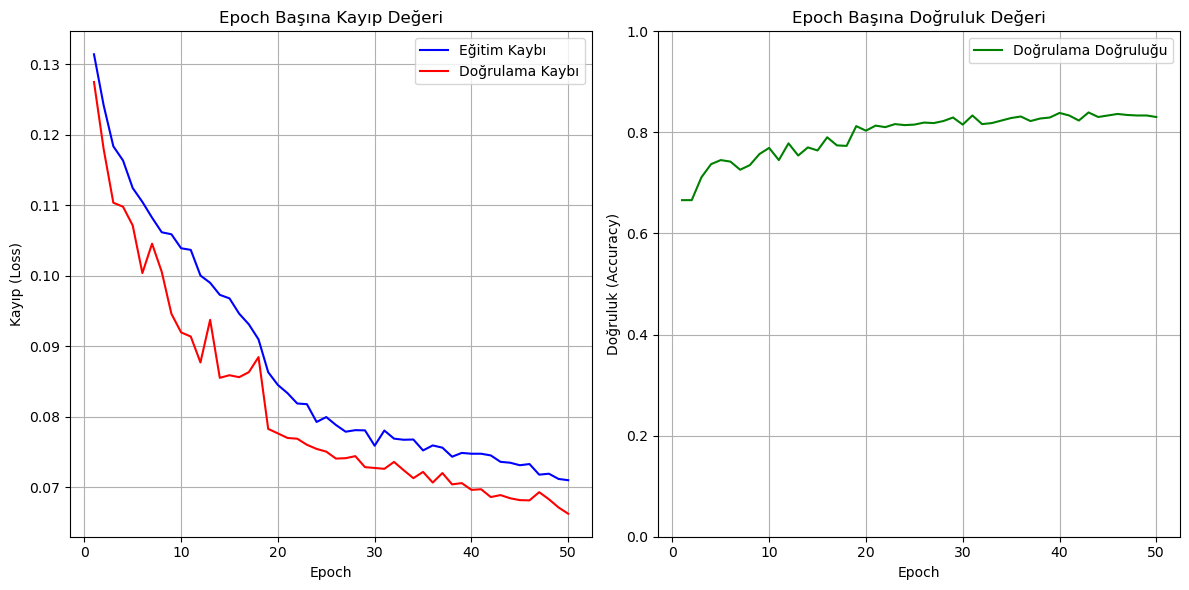

In [16]:
plt.figure("Eğitim ve Doğrulama Grafikleri", figsize=(12, 6))

# Eğitim ve Doğrulama Kayıp Grafiği
plt.subplot(1, 2, 1)
plt.title("Epoch Başına Kayıp Değeri")
plt.xlabel("Epoch")
plt.ylabel("Kayıp (Loss)")
plt.plot(range(1, max_epochs + 1), epoch_loss_values, color="blue", label="Eğitim Kaybı")
plt.plot(range(1, max_epochs + 1), val_loss_values, color="red", label="Doğrulama Kaybı")
plt.legend()
plt.grid(True)

# Doğrulama Doğruluk Grafiği
plt.subplot(1, 2, 2)
plt.title("Epoch Başına Doğruluk Değeri")
plt.xlabel("Epoch")
plt.ylabel("Doğruluk (Accuracy)")
plt.plot(range(1, max_epochs + 1), metric_values, color="green", label="Doğrulama Doğruluğu")
plt.ylim([0, 1]) # Doğruluk 0 ile 1 arasındadır
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

C:\Users\omer_\AppData\Local\Temp\ipykernel_20264\1969419798.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
Nihai Te


             NİHAİ TEST SONUÇLARI (Classification Report)
              precision    recall  f1-score   support

    Bleeding       0.54      0.34      0.42       164
    Ischemia       0.62      0.56      0.59       170
      Normal       0.88      0.98      0.92       664

    accuracy                           0.80       998
   macro avg       0.68      0.63      0.64       998
weighted avg       0.78      0.80      0.78       998


                     Karışıklık Matrisi


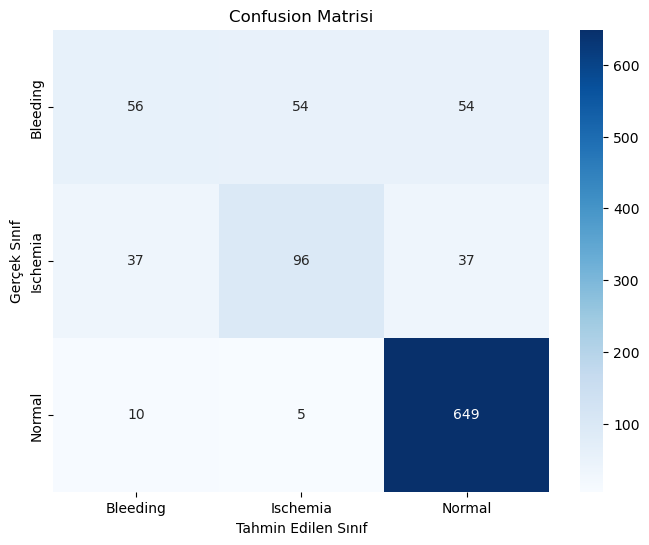

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# En iyi modeli yükle
model.load_state_dict(torch.load("best_model.pth"))
model.eval() # Değerlendirme moduna al

y_true = []
y_pred = []

with torch.no_grad():
    for test_data_batch in tqdm(test_loader, desc="Nihai Test"):
        test_images, test_labels = test_data_batch["image"].to(device), test_data_batch["label"].to(device)
        
        test_outputs = model(test_images)
        
        # Tahmin edilen sınıfı al (en yüksek skora sahip olan)
        predicted_classes = torch.argmax(test_outputs, dim=1)
        
        y_pred.extend(predicted_classes.cpu().numpy())
        y_true.extend(test_labels.cpu().numpy())

print("\n" + "="*50)
print("             NİHAİ TEST SONUÇLARI (Classification Report)")
print("="*50)
# Sınıflandırma Raporu: Precision, Recall, F1-Score
print(classification_report(y_true, y_pred, target_names=TRAIN_CLASSES))


# Karışıklık Matrisi (Confusion Matrix)
print("\n" + "="*50)
print("                     Karışıklık Matrisi")
print("="*50)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=TRAIN_CLASSES, yticklabels=TRAIN_CLASSES)
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Confusion Matrisi")
plt.show()

## Topolojik Özelliklere Giriş

In [1]:
import os
import glob
import numpy as np
from tqdm import tqdm
from PIL import Image
import pydicom
from sklearn.pipeline import Pipeline
from gtda.homology import CubicalPersistence
from gtda.diagrams import PersistenceImage
import matplotlib.pyplot as plt

DATA_DIR = r"C:\Users\omer_\Documents\GitHub\ytustats\standard_u-net\Brain_Stroke_CT_Dataset"
IMAGE_TYPE_FOLDER = 'DICOM' 
FILE_EXTENSION = '.dcm'
# Karışmaması için yeni ve temiz bir klasör adı
TDA_OUTPUT_DIR = "./topological_features" 
os.makedirs(TDA_OUTPUT_DIR, exist_ok=True)


#PIPELINE
cubical_persistence = CubicalPersistence(homology_dimensions=(0, 1), n_jobs=-1)
persistence_image = PersistenceImage(n_bins=32, n_jobs=-1)
tda_pipeline = Pipeline([
    ("cubical_persistence", cubical_persistence),
    ("persistence_image", persistence_image)
])
print("Giotto-tda pipeline'ı (v0.6.2 - CubicalPersistence) ile başarıyla tasarlandı.")

Giotto-tda pipeline'ı (v0.6.2 - CubicalPersistence) ile başarıyla tasarlandı.


In [2]:
all_image_files = []
for folder in ["Bleeding", "Ischemia", "Normal"]:
    class_dir = os.path.join(DATA_DIR, folder, IMAGE_TYPE_FOLDER)
    files = glob.glob(os.path.join(class_dir, f'*{FILE_EXTENSION}'))
    all_image_files.extend(files)
external_test_dir = os.path.join(DATA_DIR, 'External_Test', IMAGE_TYPE_FOLDER)
if os.path.isdir(external_test_dir):
    all_image_files.extend(glob.glob(os.path.join(external_test_dir, f'*{FILE_EXTENSION}')))
print(f"\nİşlenmek üzere toplam {len(all_image_files)} adet görüntü dosyası bulundu.")


İşlenmek üzere toplam 6850 adet görüntü dosyası bulundu.


In [3]:
print("\nTopolojik imzalar üretiliyor ve .npy olarak kaydediliyor...")
for file_path in tqdm(all_image_files, desc="Topolojik İmza Üretimi"):
    try:
        # --- Görüntüyü Oku ve 2D Hale Getir ---
        if FILE_EXTENSION == '.dcm':
            image_array = pydicom.dcmread(file_path).pixel_array
        else:
            image_array = np.array(Image.open(file_path).convert("L"))

        if image_array.ndim == 3:
            middle_slice_index = image_array.shape[0] // 2
            final_image_2d = image_array[middle_slice_index, :, :]
        elif image_array.ndim == 2:
            final_image_2d = image_array
        else:
            continue
        # CubicalPersistence, (n_samples, height, width) şeklinde 3D bir dizi bekler.
        # Nokta bulutu, yeniden boyutlandırma, sahte RGB gibi adımlara GEREK YOKTUR.
        image_for_gtda = final_image_2d[np.newaxis, :, :]
        
        persistence_images = tda_pipeline.fit_transform(image_for_gtda)
        topological_feature = persistence_images[0]
        
        base_filename = os.path.basename(file_path)
        filename_without_ext = os.path.splitext(base_filename)[0]
        output_npy_path = os.path.join(TDA_OUTPUT_DIR, f"{filename_without_ext}.npy")
        np.save(output_npy_path, topological_feature)

    except Exception as e:
        print(f"\nHATA: '{file_path}' dosyası işlenirken bir sorun oluştu.")
        print(f"Hata mesajı: {e}")
        continue

print("\nİşlem tamamlandı!")
print(f"Tüm topolojik imzalar '{TDA_OUTPUT_DIR}' klasörüne kaydedildi.")


Topolojik imzalar üretiliyor ve .npy olarak kaydediliyor...


Topolojik İmza Üretimi: 100%|██████████| 6850/6850 [8:31:26<00:00,  4.48s/it]  


İşlem tamamlandı!
Tüm topolojik imzalar './topological_features' klasörüne kaydedildi.


## Hibrit Model 

In [10]:
import torch
import numpy as np
import os
from monai.data import Dataset
# --- DEĞİŞİKLİK BURADA: Artık MapLabel veya ToTensor'ı buradan import etmiyoruz ---
# Onları asıl transform zincirinde (train_transforms) zaten import etmiştik.

# Bu, bizim özel veri yükleyicimiz. MONAI'nin standart Dataset sınıfından miras alıyor.
class HybridDataset(Dataset):
    def __init__(self, image_files_and_labels, tda_dir, transform=None):
        # ... (init kısmı aynı)
        self.image_files_and_labels = image_files_and_labels
        self.tda_dir = tda_dir
        self.transform = transform
    
    def __len__(self):
        # ... (len kısmı aynı)
        return len(self.image_files_and_labels)

    def __getitem__(self, index):
        item_metadata = self.image_files_and_labels[index]
        
        if self.transform:
            processed_item = self.transform(item_metadata)
        else:
            processed_item = item_metadata
        
        image_path = item_metadata['image']
        base_filename = os.path.basename(image_path)
        filename_without_ext = os.path.splitext(base_filename)[0]
        npy_path = os.path.join(self.tda_dir, f"{filename_without_ext}.npy")
        
        if os.path.exists(npy_path):
            tda_feature_raw = np.load(npy_path) # Şekli (2, 32, 32)
            
            # --- KRİTİK DEĞİŞİKLİK: İki homoloji boyutunu birleştiriyoruz ---
            # İki adet (32, 32)'lik görüntüyü tek bir (2, 32, 32) tensör olarak ele alacağız.
            # Artık (1, 32, 32) yerine (2, 32, 32) olacak.
            processed_item['tda_feature'] = torch.from_numpy(tda_feature_raw).float()

        else:
            print(f"UYARI: {npy_path} bulunamadı!")
            # Boyutun tutarlı olması için (2, 32, 32)'lik sıfır tensörü oluşturuyoruz
            processed_item['tda_feature'] = torch.zeros((2, 32, 32), dtype=torch.float32)

        return processed_item

# --- Yeni DataLoader'ları Oluştur ---
# .npy dosyalarının bulunduğu klasörün adını doğru yazdığınızdan emin olun
TDA_DIR = "./topological_features_cubical" 

# 1. Faz'daki veri listelerimizi (train_data, val_data, test_data) ve 
# transformlarımızı (train_transforms, val_transforms) burada tekrar kullanıyoruz.

# Hibrit Dataset'lerimizi oluşturalım
hybrid_train_dataset = HybridDataset(train_data, TDA_DIR, transform=train_transforms)
hybrid_val_dataset = HybridDataset(val_data, TDA_DIR, transform=val_transforms)
hybrid_test_dataset = HybridDataset(test_data, TDA_DIR, transform=val_transforms)

# Yeni Hibrit DataLoader'lar
hybrid_train_loader = DataLoader(hybrid_train_dataset, batch_size=8, shuffle=True, num_workers=0)
hybrid_val_loader = DataLoader(hybrid_val_dataset, batch_size=8, shuffle=False, num_workers=0)
hybrid_test_loader = DataLoader(hybrid_test_dataset, batch_size=8, shuffle=False, num_workers=0)

print("Hibrit veri yükleyicileri başarıyla oluşturuldu.")
check_batch = next(iter(hybrid_train_loader))
print("\nBir batch hibrit veri kontrolü:")
print(f"Görüntü tensörünün boyutu: {check_batch['image'].shape}")
print(f"TDA özellik tensörünün boyutu: {check_batch['tda_feature'].shape}")
print(f"Etiket tensörünün boyutu: {check_batch['label'].shape}")


Hibrit veri yükleyicileri başarıyla oluşturuldu.

Bir batch hibrit veri kontrolü:
Görüntü tensörünün boyutu: torch.Size([8, 1, 256, 256])
TDA özellik tensörünün boyutu: torch.Size([8, 2, 32, 32])
Etiket tensörünün boyutu: torch.Size([8])


In [11]:
# --- Adım 3.2: HİBRİT U-NET MİMARİSİ (EN BASİT VE SAĞLAM VERSİYON) ---
import torch.nn as nn
from monai.networks.nets import UNet

class HybridUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        # 1. Görsel özellikler için U-Net'in tamamı.
        # Çıktı kanalını küçük tutarak bellek kullanımını kontrol ediyoruz.
        self.unet = UNet(
            spatial_dims=2, in_channels=in_channels, out_channels=32, # Çıktı kanalı 32
            channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2),
            num_res_units=2
        )
        
        # 2. TDA Özelliklerini işleyecek küçük bir ağ (MLP).
        # Girdi: (batch, 2, 32, 32). Çıktı: (batch, 128)
        self.tda_processor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2 * 32 * 32, 512), # 2048 -> 512
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 128) # 512 -> 128
        )
        
        # 3. U-Net ve TDA çıktısını birleştiren son sınıflandırıcı
        # U-Net çıktısı (düzleştirilmiş): 32 kanal * 256 * 256 = 2097152 (ÇOK BÜYÜK!)
        # Bu yüzden bir havuzlama katmanı ekleyeceğiz.
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # U-Net'ten gelen özellik (32) + TDA'dan gelen özellik (128) = 160
        self.final_classifier = nn.Sequential(
            nn.Linear(32 + 128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, out_channels)
        )

    def forward(self, image, tda_feature):
        # 1. Görüntüyü U-Net'ten geçir -> (batch, 32, 256, 256)
        image_features = self.unet(image)
        
        # 2. U-Net çıktısını havuzlayarak tek bir vektöre indirge -> (batch, 32)
        pooled_image_features = self.pool(image_features)
        flat_image_features = torch.flatten(pooled_image_features, 1)
        
        # 3. TDA özelliğini işle -> (batch, 128)
        processed_tda_feature = self.tda_processor(tda_feature)
        
        # 4. İki düz vektörü birleştir -> (batch, 32 + 128 = 160)
        combined_features = torch.cat([flat_image_features, processed_tda_feature], dim=1)
        
        # 5. Birleşik vektörü nihai sınıflandırıcıdan geçir
        output = self.final_classifier(combined_features)
        
        return output

# --- Modeli, Optimizer'ı ve Diğerlerini Tanımla ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hybrid_model = HybridUNet(in_channels=1, out_channels=3).to(device)

# Optimizer için daha yüksek bir öğrenme oranıyla başlayalım
optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=1e-4)

# Diğerleri aynı
weights = torch.tensor([4.0, 4.0, 1.0], dtype=torch.float32).to(device)
loss_function = nn.CrossEntropyLoss(weight=weights)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

print("\nHibrit modelin son ve en BASİT mimarisi başarıyla oluşturuldu.")


Hibrit modelin son ve en BASİT mimarisi başarıyla oluşturuldu.


In [12]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- HİBRİT EĞİTİM AYARLARI ---
# Ayarların çoğu zaten bir önceki hücrede (model tanımı hücresi) yapıldı.
# Burada sadece epoch ve metrik listelerini tanımlıyoruz.
max_epochs = 50
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
val_loss_values = []
metric_values = [] 

In [13]:
# --- EĞİTİM VE DOĞRULAMA DÖNGÜSÜ ---
from torch.optim.lr_scheduler import ReduceLROnPlateau
for epoch in range(max_epochs):
    print("-" * 20)
    print(f"Epoch {epoch + 1}/{max_epochs}")
    
    hybrid_model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in tqdm(hybrid_train_loader, desc="Hibrit Eğitim"):
        step += 1
        inputs, tda_features, labels = (
            batch_data["image"].to(device),
            batch_data["tda_feature"].to(device),
            batch_data["label"].to(device),
        )
        
        optimizer.zero_grad()
        outputs = hybrid_model(inputs, tda_features)
        loss = loss_function(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(hybrid_model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1} Ortalama Eğitim Kaybı: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        hybrid_model.eval()
        val_epoch_loss = 0
        val_step = 0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for val_batch in tqdm(hybrid_val_loader, desc="Hibrit Doğrulama"):
                val_step += 1
                val_images, val_tda, val_labels = (
                    val_batch["image"].to(device),
                    val_batch["tda_feature"].to(device),
                    val_batch["label"].to(device),
                )
                val_outputs = hybrid_model(val_images, val_tda)
                loss = loss_function(val_outputs, val_labels)
                val_epoch_loss += loss.item()
                predicted_classes = torch.argmax(val_outputs, dim=1)
                correct_predictions += (predicted_classes == val_labels).sum().item()
                total_samples += val_labels.size(0)
            
            mean_val_accuracy = correct_predictions / total_samples
            metric_values.append(mean_val_accuracy)
            
            val_epoch_loss /= val_step
            val_loss_values.append(val_epoch_loss)

            if mean_val_accuracy > best_metric:
                best_metric = mean_val_accuracy
                best_metric_epoch = epoch + 1
                torch.save(hybrid_model.state_dict(), "best_hybrid_model.pth")
                print("yeni en iyi hibrit metrik kaydedildi!")

            print(
                f"Epoch {epoch + 1} Ortalama Doğrulama Kaybı: {val_epoch_loss:.4f} "
                f"| Doğruluk: {mean_val_accuracy:.4f}"
            )
            print(
                f"En iyi metrik şu ana kadar: {best_metric:.4f} "
                f"(epoch {best_metric_epoch})")
            
        scheduler.step(val_epoch_loss)

print(f"\nHibrit eğitim tamamlandı. En iyi model 'best_hybrid_model.pth' olarak kaydedildi.")

--------------------
Epoch 1/50


Hibrit Eğitim: 100%|██████████| 582/582 [03:50<00:00,  2.53it/s]


Epoch 1 Ortalama Eğitim Kaybı: 1.0934


Hibrit Doğrulama: 100%|██████████| 125/125 [00:40<00:00,  3.09it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 1 Ortalama Doğrulama Kaybı: 1.0771 | Doğruluk: 0.6690
En iyi metrik şu ana kadar: 0.6690 (epoch 1)
--------------------
Epoch 2/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.79it/s]


Epoch 2 Ortalama Eğitim Kaybı: 1.0518


Hibrit Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.83it/s]


Epoch 2 Ortalama Doğrulama Kaybı: 1.0141 | Doğruluk: 0.6489
En iyi metrik şu ana kadar: 0.6690 (epoch 1)
--------------------
Epoch 3/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:32<00:00,  3.81it/s]


Epoch 3 Ortalama Eğitim Kaybı: 1.0090


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.79it/s]


Epoch 3 Ortalama Doğrulama Kaybı: 0.9852 | Doğruluk: 0.6098
En iyi metrik şu ana kadar: 0.6690 (epoch 1)
--------------------
Epoch 4/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.79it/s]


Epoch 4 Ortalama Eğitim Kaybı: 0.9801


Hibrit Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.84it/s]


Epoch 4 Ortalama Doğrulama Kaybı: 0.9561 | Doğruluk: 0.6058
En iyi metrik şu ana kadar: 0.6690 (epoch 1)
--------------------
Epoch 5/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.78it/s]


Epoch 5 Ortalama Eğitim Kaybı: 0.9587


Hibrit Doğrulama: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]


Epoch 5 Ortalama Doğrulama Kaybı: 0.9223 | Doğruluk: 0.6319
En iyi metrik şu ana kadar: 0.6690 (epoch 1)
--------------------
Epoch 6/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:38<00:00,  3.67it/s]


Epoch 6 Ortalama Eğitim Kaybı: 0.9403


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.68it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 6 Ortalama Doğrulama Kaybı: 0.8805 | Doğruluk: 0.6760
En iyi metrik şu ana kadar: 0.6760 (epoch 6)
--------------------
Epoch 7/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:38<00:00,  3.66it/s]


Epoch 7 Ortalama Eğitim Kaybı: 0.9200


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.67it/s]


Epoch 7 Ortalama Doğrulama Kaybı: 0.8640 | Doğruluk: 0.6620
En iyi metrik şu ana kadar: 0.6760 (epoch 6)
--------------------
Epoch 8/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:38<00:00,  3.67it/s]


Epoch 8 Ortalama Eğitim Kaybı: 0.9041


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.65it/s]


Epoch 8 Ortalama Doğrulama Kaybı: 0.8616 | Doğruluk: 0.6369
En iyi metrik şu ana kadar: 0.6760 (epoch 6)
--------------------
Epoch 9/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:38<00:00,  3.66it/s]


Epoch 9 Ortalama Eğitim Kaybı: 0.8929


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.69it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 9 Ortalama Doğrulama Kaybı: 0.8378 | Doğruluk: 0.6810
En iyi metrik şu ana kadar: 0.6810 (epoch 9)
--------------------
Epoch 10/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:38<00:00,  3.66it/s]


Epoch 10 Ortalama Eğitim Kaybı: 0.8714


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.66it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 10 Ortalama Doğrulama Kaybı: 0.8158 | Doğruluk: 0.6901
En iyi metrik şu ana kadar: 0.6901 (epoch 10)
--------------------
Epoch 11/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:37<00:00,  3.70it/s]


Epoch 11 Ortalama Eğitim Kaybı: 0.8529


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.67it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 11 Ortalama Doğrulama Kaybı: 0.8019 | Doğruluk: 0.7121
En iyi metrik şu ana kadar: 0.7121 (epoch 11)
--------------------
Epoch 12/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:38<00:00,  3.68it/s]


Epoch 12 Ortalama Eğitim Kaybı: 0.8503


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch 12 Ortalama Doğrulama Kaybı: 0.7841 | Doğruluk: 0.7091
En iyi metrik şu ana kadar: 0.7121 (epoch 11)
--------------------
Epoch 13/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:35<00:00,  3.75it/s]


Epoch 13 Ortalama Eğitim Kaybı: 0.8239


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.80it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 13 Ortalama Doğrulama Kaybı: 0.7922 | Doğruluk: 0.7161
En iyi metrik şu ana kadar: 0.7161 (epoch 13)
--------------------
Epoch 14/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:34<00:00,  3.77it/s]


Epoch 14 Ortalama Eğitim Kaybı: 0.8164


Hibrit Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.82it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 14 Ortalama Doğrulama Kaybı: 0.7574 | Doğruluk: 0.7292
En iyi metrik şu ana kadar: 0.7292 (epoch 14)
--------------------
Epoch 15/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:34<00:00,  3.77it/s]


Epoch 15 Ortalama Eğitim Kaybı: 0.8031


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.81it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 15 Ortalama Doğrulama Kaybı: 0.8149 | Doğruluk: 0.7753
En iyi metrik şu ana kadar: 0.7753 (epoch 15)
--------------------
Epoch 16/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:34<00:00,  3.76it/s]


Epoch 16 Ortalama Eğitim Kaybı: 0.7992


Hibrit Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.82it/s]


Epoch 16 Ortalama Doğrulama Kaybı: 0.7532 | Doğruluk: 0.7111
En iyi metrik şu ana kadar: 0.7753 (epoch 15)
--------------------
Epoch 17/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:34<00:00,  3.76it/s]


Epoch 17 Ortalama Eğitim Kaybı: 0.7855


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.81it/s]


Epoch 17 Ortalama Doğrulama Kaybı: 0.7503 | Doğruluk: 0.7262
En iyi metrik şu ana kadar: 0.7753 (epoch 15)
--------------------
Epoch 18/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:34<00:00,  3.77it/s]


Epoch 18 Ortalama Eğitim Kaybı: 0.7505


Hibrit Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.98it/s]


Epoch 18 Ortalama Doğrulama Kaybı: 0.7483 | Doğruluk: 0.7643
En iyi metrik şu ana kadar: 0.7753 (epoch 15)
--------------------
Epoch 19/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:28<00:00,  3.92it/s]


Epoch 19 Ortalama Eğitim Kaybı: 0.7400


Hibrit Doğrulama: 100%|██████████| 125/125 [00:24<00:00,  5.05it/s]


Epoch 19 Ortalama Doğrulama Kaybı: 0.7467 | Doğruluk: 0.7743
En iyi metrik şu ana kadar: 0.7753 (epoch 15)
--------------------
Epoch 20/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:28<00:00,  3.92it/s]


Epoch 20 Ortalama Eğitim Kaybı: 0.7329


Hibrit Doğrulama: 100%|██████████| 125/125 [00:24<00:00,  5.07it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 20 Ortalama Doğrulama Kaybı: 0.7000 | Doğruluk: 0.7773
En iyi metrik şu ana kadar: 0.7773 (epoch 20)
--------------------
Epoch 21/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:37<00:00,  3.70it/s]


Epoch 21 Ortalama Eğitim Kaybı: 0.7224


Hibrit Doğrulama: 100%|██████████| 125/125 [00:27<00:00,  4.48it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 21 Ortalama Doğrulama Kaybı: 0.7566 | Doğruluk: 0.7944
En iyi metrik şu ana kadar: 0.7944 (epoch 21)
--------------------
Epoch 22/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:34<00:00,  3.76it/s]


Epoch 22 Ortalama Eğitim Kaybı: 0.7232


Hibrit Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.89it/s]


Epoch 22 Ortalama Doğrulama Kaybı: 0.6853 | Doğruluk: 0.7061
En iyi metrik şu ana kadar: 0.7944 (epoch 21)
--------------------
Epoch 23/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:28<00:00,  3.91it/s]


Epoch 23 Ortalama Eğitim Kaybı: 0.6887


Hibrit Doğrulama: 100%|██████████| 125/125 [00:24<00:00,  5.01it/s]


Epoch 23 Ortalama Doğrulama Kaybı: 0.6789 | Doğruluk: 0.7773
En iyi metrik şu ana kadar: 0.7944 (epoch 21)
--------------------
Epoch 24/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:29<00:00,  3.89it/s]


Epoch 24 Ortalama Eğitim Kaybı: 0.6830


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


Epoch 24 Ortalama Doğrulama Kaybı: 0.6868 | Doğruluk: 0.7904
En iyi metrik şu ana kadar: 0.7944 (epoch 21)
--------------------
Epoch 25/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.80it/s]


Epoch 25 Ortalama Eğitim Kaybı: 0.6842


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


Epoch 25 Ortalama Doğrulama Kaybı: 0.6452 | Doğruluk: 0.7823
En iyi metrik şu ana kadar: 0.7944 (epoch 21)
--------------------
Epoch 26/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.78it/s]


Epoch 26 Ortalama Eğitim Kaybı: 0.6603


Hibrit Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.83it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 26 Ortalama Doğrulama Kaybı: 0.6458 | Doğruluk: 0.8094
En iyi metrik şu ana kadar: 0.8094 (epoch 26)
--------------------
Epoch 27/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:32<00:00,  3.81it/s]


Epoch 27 Ortalama Eğitim Kaybı: 0.6474


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.76it/s]


Epoch 27 Ortalama Doğrulama Kaybı: 0.6469 | Doğruluk: 0.7844
En iyi metrik şu ana kadar: 0.8094 (epoch 26)
--------------------
Epoch 28/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:32<00:00,  3.81it/s]


Epoch 28 Ortalama Eğitim Kaybı: 0.6409


Hibrit Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.83it/s]


Epoch 28 Ortalama Doğrulama Kaybı: 0.6573 | Doğruluk: 0.7352
En iyi metrik şu ana kadar: 0.8094 (epoch 26)
--------------------
Epoch 29/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:32<00:00,  3.81it/s]


Epoch 29 Ortalama Eğitim Kaybı: 0.6381


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.78it/s]


Epoch 29 Ortalama Doğrulama Kaybı: 0.6522 | Doğruluk: 0.8054
En iyi metrik şu ana kadar: 0.8094 (epoch 26)
--------------------
Epoch 30/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:28<00:00,  3.91it/s]


Epoch 30 Ortalama Eğitim Kaybı: 0.6202


Hibrit Doğrulama: 100%|██████████| 125/125 [00:24<00:00,  5.06it/s]


Epoch 30 Ortalama Doğrulama Kaybı: 0.6278 | Doğruluk: 0.8024
En iyi metrik şu ana kadar: 0.8094 (epoch 26)
--------------------
Epoch 31/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:29<00:00,  3.89it/s]


Epoch 31 Ortalama Eğitim Kaybı: 0.5889


Hibrit Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.82it/s]


Epoch 31 Ortalama Doğrulama Kaybı: 0.6658 | Doğruluk: 0.8094
En iyi metrik şu ana kadar: 0.8094 (epoch 26)
--------------------
Epoch 32/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.80it/s]


Epoch 32 Ortalama Eğitim Kaybı: 0.6109


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.76it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 32 Ortalama Doğrulama Kaybı: 0.6375 | Doğruluk: 0.8195
En iyi metrik şu ana kadar: 0.8195 (epoch 32)
--------------------
Epoch 33/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.80it/s]


Epoch 33 Ortalama Eğitim Kaybı: 0.5870


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 33 Ortalama Doğrulama Kaybı: 0.6931 | Doğruluk: 0.8215
En iyi metrik şu ana kadar: 0.8215 (epoch 33)
--------------------
Epoch 34/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.79it/s]


Epoch 34 Ortalama Eğitim Kaybı: 0.5667


Hibrit Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.82it/s]


Epoch 34 Ortalama Doğrulama Kaybı: 0.6390 | Doğruluk: 0.8104
En iyi metrik şu ana kadar: 0.8215 (epoch 33)
--------------------
Epoch 35/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:34<00:00,  3.77it/s]


Epoch 35 Ortalama Eğitim Kaybı: 0.5835


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.66it/s]


Epoch 35 Ortalama Doğrulama Kaybı: 0.6231 | Doğruluk: 0.8144
En iyi metrik şu ana kadar: 0.8215 (epoch 33)
--------------------
Epoch 36/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:34<00:00,  3.78it/s]


Epoch 36 Ortalama Eğitim Kaybı: 0.5682


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.75it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 36 Ortalama Doğrulama Kaybı: 0.6698 | Doğruluk: 0.8445
En iyi metrik şu ana kadar: 0.8445 (epoch 36)
--------------------
Epoch 37/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.79it/s]


Epoch 37 Ortalama Eğitim Kaybı: 0.5581


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.75it/s]


Epoch 37 Ortalama Doğrulama Kaybı: 0.5952 | Doğruluk: 0.8425
En iyi metrik şu ana kadar: 0.8445 (epoch 36)
--------------------
Epoch 38/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.78it/s]


Epoch 38 Ortalama Eğitim Kaybı: 0.5450


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


Epoch 38 Ortalama Doğrulama Kaybı: 0.5847 | Doğruluk: 0.8134
En iyi metrik şu ana kadar: 0.8445 (epoch 36)
--------------------
Epoch 39/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.79it/s]


Epoch 39 Ortalama Eğitim Kaybı: 0.5434


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.78it/s]


Epoch 39 Ortalama Doğrulama Kaybı: 0.5669 | Doğruluk: 0.8445
En iyi metrik şu ana kadar: 0.8445 (epoch 36)
--------------------
Epoch 40/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.78it/s]


Epoch 40 Ortalama Eğitim Kaybı: 0.5316


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.79it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 40 Ortalama Doğrulama Kaybı: 0.6681 | Doğruluk: 0.8576
En iyi metrik şu ana kadar: 0.8576 (epoch 40)
--------------------
Epoch 41/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.80it/s]


Epoch 41 Ortalama Eğitim Kaybı: 0.5237


Hibrit Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  5.00it/s]


Epoch 41 Ortalama Doğrulama Kaybı: 0.6746 | Doğruluk: 0.7813
En iyi metrik şu ana kadar: 0.8576 (epoch 40)
--------------------
Epoch 42/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:28<00:00,  3.92it/s]


Epoch 42 Ortalama Eğitim Kaybı: 0.5338


Hibrit Doğrulama: 100%|██████████| 125/125 [00:24<00:00,  5.03it/s]


Epoch 42 Ortalama Doğrulama Kaybı: 0.7775 | Doğruluk: 0.7222
En iyi metrik şu ana kadar: 0.8576 (epoch 40)
--------------------
Epoch 43/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.79it/s]


Epoch 43 Ortalama Eğitim Kaybı: 0.5031


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.75it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 43 Ortalama Doğrulama Kaybı: 0.6837 | Doğruluk: 0.8646
En iyi metrik şu ana kadar: 0.8646 (epoch 43)
--------------------
Epoch 44/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.78it/s]


Epoch 44 Ortalama Eğitim Kaybı: 0.5117


Hibrit Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.81it/s]


Epoch 44 Ortalama Doğrulama Kaybı: 0.6022 | Doğruluk: 0.8455
En iyi metrik şu ana kadar: 0.8646 (epoch 43)
--------------------
Epoch 45/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:34<00:00,  3.77it/s]


Epoch 45 Ortalama Eğitim Kaybı: 0.5209


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.67it/s]


Epoch 45 Ortalama Doğrulama Kaybı: 0.7789 | Doğruluk: 0.8465
En iyi metrik şu ana kadar: 0.8646 (epoch 43)
--------------------
Epoch 46/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:34<00:00,  3.77it/s]


Epoch 46 Ortalama Eğitim Kaybı: 0.4441


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.77it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 46 Ortalama Doğrulama Kaybı: 0.5310 | Doğruluk: 0.8706
En iyi metrik şu ana kadar: 0.8706 (epoch 46)
--------------------
Epoch 47/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:32<00:00,  3.80it/s]


Epoch 47 Ortalama Eğitim Kaybı: 0.3999


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.79it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 47 Ortalama Doğrulama Kaybı: 0.5044 | Doğruluk: 0.8776
En iyi metrik şu ana kadar: 0.8776 (epoch 47)
--------------------
Epoch 48/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.79it/s]


Epoch 48 Ortalama Eğitim Kaybı: 0.3848


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.78it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 48 Ortalama Doğrulama Kaybı: 0.5153 | Doğruluk: 0.8786
En iyi metrik şu ana kadar: 0.8786 (epoch 48)
--------------------
Epoch 49/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.78it/s]


Epoch 49 Ortalama Eğitim Kaybı: 0.3785


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.76it/s]


Epoch 49 Ortalama Doğrulama Kaybı: 0.5282 | Doğruluk: 0.8786
En iyi metrik şu ana kadar: 0.8786 (epoch 48)
--------------------
Epoch 50/50


Hibrit Eğitim: 100%|██████████| 582/582 [02:33<00:00,  3.80it/s]


Epoch 50 Ortalama Eğitim Kaybı: 0.3659


Hibrit Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.75it/s]

Epoch 50 Ortalama Doğrulama Kaybı: 0.5299 | Doğruluk: 0.8786
En iyi metrik şu ana kadar: 0.8786 (epoch 48)

Hibrit eğitim tamamlandı. En iyi model 'best_hybrid_model.pth' olarak kaydedildi.


C:\Users\omer_\AppData\Local\Temp\ipykernel_10228\1398242182.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hybrid_model.load_state_dict(torch.load(model_path))


'best_hybrid_model.pth' dosyasından hibrit model ağırlıkları başarıyla yüklendi.



Hibrit Model Test Ediliyor: 100%|██████████| 125/125 [00:42<00:00,  2.95it/s]


             HİBRİT MODEL NİHAİ TEST SONUÇLARI

--- Sınıflandırma Raporu ---

              precision    recall  f1-score   support

    Bleeding       0.67      0.74      0.71       164
    Ischemia       0.83      0.81      0.82       170
      Normal       0.94      0.92      0.93       664

    accuracy                           0.87       998
   macro avg       0.81      0.82      0.82       998
weighted avg       0.87      0.87      0.87       998


                     Karışıklık Matrisi


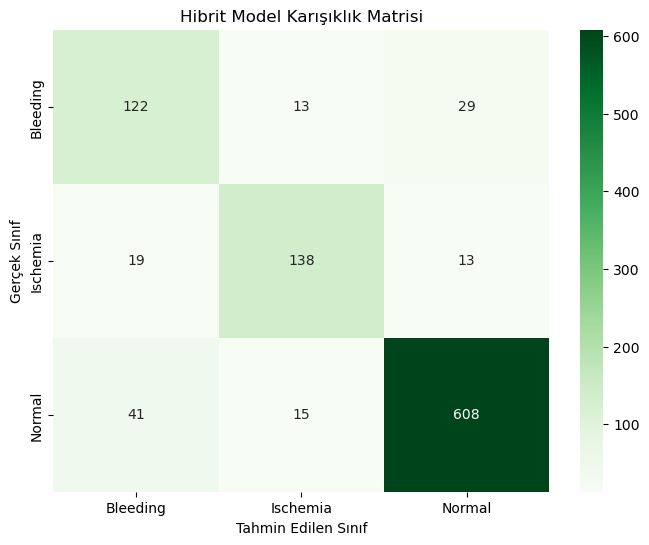

In [15]:
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from monai.networks.nets import UNet

# --- 1. HİBRİT MODEL SINIFINI TEKRAR TANIMLA ---
# Notebook'u yeniden başlattıysanız bu tanım gereklidir.
class HybridUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.unet = UNet(
            spatial_dims=2, in_channels=in_channels, out_channels=32,
            channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2),
            num_res_units=2
        )
        self.tda_processor = nn.Sequential(
            nn.Flatten(), nn.Linear(2 * 32 * 32, 512),
            nn.LeakyReLU(0.2, inplace=True), nn.Linear(512, 128)
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.final_classifier = nn.Sequential(
            nn.Linear(32 + 128, 64), nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5), nn.Linear(64, out_channels)
        )

    def forward(self, image, tda_feature):
        image_features = self.unet(image)
        pooled_image_features = self.pool(image_features)
        flat_image_features = torch.flatten(pooled_image_features, 1)
        processed_tda_feature = self.tda_processor(tda_feature)
        combined_features = torch.cat([flat_image_features, processed_tda_feature], dim=1)
        output = self.final_classifier(combined_features)
        return output

# --- 2. MODELİ YÜKLE VE HAZIRLA ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Boş bir hibrit model oluştur ve GPU'ya gönder
hybrid_model = HybridUNet(in_channels=1, out_channels=3).to(device)

# En iyi eğitilmiş ağırlıkları yükle
model_path = "best_hybrid_model.pth"
hybrid_model.load_state_dict(torch.load(model_path))

# Modeli değerlendirme moduna al (Dropout vb. katmanları kapatır)
hybrid_model.eval()

print(f"'{model_path}' dosyasından hibrit model ağırlıkları başarıyla yüklendi.\n")


# --- 3. MODELİ TEST VERİSİ ÜZERİNDE ÇALIŞTIR ---
y_true = []
y_pred = []

with torch.no_grad(): # Gradyan hesaplamayı kapatarak belleği ve hızı optimize et
    for test_batch in tqdm(hybrid_test_loader, desc="Hibrit Model Test Ediliyor"):
        # Verileri GPU'ya gönder
        test_images, test_tda, test_labels = (
            test_batch["image"].to(device),
            test_batch["tda_feature"].to(device),
            test_batch["label"].to(device),
        )
        
        # Modelden tahminleri al
        test_outputs = hybrid_model(test_images, test_tda)
        
        # Tahmin edilen sınıfı al (en yüksek skora sahip olanın indeksi)
        predicted_classes = torch.argmax(test_outputs, dim=1)
        
        # Tahminleri ve gerçek etiketleri listelere ekle
        y_pred.extend(predicted_classes.cpu().numpy())
        y_true.extend(test_labels.cpu().numpy())


# --- 4. SONUÇLARI RAPORLA ---
print("\n" + "="*50)
print("             HİBRİT MODEL NİHAİ TEST SONUÇLARI")
print("="*50)

# Sınıflandırma Raporu (Classification Report)
print("\n--- Sınıflandırma Raporu ---\n")
print(classification_report(y_true, y_pred, target_names=TRAIN_CLASSES))


# Karışıklık Matrisi (Confusion Matrix)
print("\n" + "="*50)
print("                     Karışıklık Matrisi")
print("="*50)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=TRAIN_CLASSES, yticklabels=TRAIN_CLASSES)
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Hibrit Model Karışıklık Matrisi")
plt.show()

## Standart Model ile Hibrit Model Karşılaştırması

In [18]:
baseline_model = ClassificationUNet(in_channels=1, out_channels=3).to(device)
baseline_model.load_state_dict(torch.load("best_model.pth"))
baseline_model.eval()

# Hibrit modeli oluştur ve eğitilmiş ağırlıkları yükle
hybrid_model = HybridUNet(in_channels=1, out_channels=3).to(device)
hybrid_model.load_state_dict(torch.load("best_hybrid_model.pth"))
hybrid_model.eval()

print("Her iki model de başarıyla yüklendi ve değerlendirme moduna alındı.\n")


# --- 3. BASELINE MODELİ TEST ET ---
y_true_baseline = []
y_pred_baseline = []
with torch.no_grad():
    for test_batch in tqdm(test_loader, desc="Baseline Model Test Ediliyor"):
        test_images, test_labels = (
            test_batch["image"].to(device),
            test_batch["label"].to(device),
        )
        test_outputs = baseline_model(test_images)
        predicted_classes = torch.argmax(test_outputs, dim=1)
        y_pred_baseline.extend(predicted_classes.cpu().numpy())
        y_true_baseline.extend(test_labels.cpu().numpy())


# --- 4. HİBRİT MODELİ TEST ET ---
y_true_hybrid = []
y_pred_hybrid = []
with torch.no_grad():
    for test_batch in tqdm(hybrid_test_loader, desc="Hibrit Model Test Ediliyor"):
        test_images, test_tda, test_labels = (
            test_batch["image"].to(device),
            test_batch["tda_feature"].to(device),
            test_batch["label"].to(device),
        )
        test_outputs = hybrid_model(test_images, test_tda)
        predicted_classes = torch.argmax(test_outputs, dim=1)
        y_pred_hybrid.extend(predicted_classes.cpu().numpy())
        y_true_hybrid.extend(test_labels.cpu().numpy())


# --- 5. SONUÇLARI YAN YANA GÖSTER ---
print("\n" + "="*70)
print(" " * 20 + "MODEL PERFORMANS KARŞILAŞTIRMASI")
print("="*70)

print("\n" + "-"*30)
print("BASELINE MODEL SONUÇLARI")
print("-"*30)
print(classification_report(y_true_baseline, y_pred_baseline, target_names=TRAIN_CLASSES))

print("\n" + "-"*30)
print("HİBRİT MODEL SONUÇLARI")
print("-"*30)
print(classification_report(y_true_hybrid, y_pred_hybrid, target_names=TRAIN_CLASSES))

print("\n" + "="*70)

C:\Users\omer_\AppData\Local\Temp\ipykernel_10228\1760708055.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  baseline_model.load_state_dict(torch.load("best_model.pth"))

Her iki model de başarıyla yüklendi ve değerlendirme moduna alındı.



Hibrit Model Test Ediliyor: 100%|██████████| 125/125 [00:25<00:00,  4.91it/s]


                    MODEL PERFORMANS KARŞILAŞTIRMASI

------------------------------
BASELINE MODEL SONUÇLARI
------------------------------
              precision    recall  f1-score   support

    Bleeding       0.54      0.34      0.42       164
    Ischemia       0.62      0.56      0.59       170
      Normal       0.88      0.98      0.92       664

    accuracy                           0.80       998
   macro avg       0.68      0.63      0.64       998
weighted avg       0.78      0.80      0.78       998


------------------------------
HİBRİT MODEL SONUÇLARI
------------------------------
              precision    recall  f1-score   support

    Bleeding       0.67      0.74      0.71       164
    Ischemia       0.83      0.81      0.82       170
      Normal       0.94      0.92      0.93       664

    accuracy                           0.87       998
   macro avg       0.81      0.82      0.82       998
weighted avg       0.87      0.87      0.87       998




## Harici Test Verisi

In [11]:
# --- Harici Test Veri Listesini Oluşturma ---

import pandas as pd
import os

print("Harici Test veri listesi oluşturuluyor...")

# Gerekli ayarların tanımlı olduğundan emin olalım
# (Bu değişkenler, notebook'unuzun başındaki hücrelerde tanımlanmış olmalı)
# DATA_DIR = r"C:\..."
# IMAGE_TYPE_FOLDER = 'DICOM'
# FILE_EXTENSION = '.dcm'

# CSV dosyanızdaki doğru sütun adları
IMAGE_COLUMN_NAME = 'image_id'
LABEL_COLUMN_NAME = 'Stroke'

# Harici test seti dosyalarının yolları
external_test_dir = os.path.join(DATA_DIR, 'External_Test')
external_labels_path = os.path.join(external_test_dir, 'labels.csv')
external_images_dir = os.path.join(external_test_dir, IMAGE_TYPE_FOLDER)

# Boş listeyi tanımla
external_data_list = []

# CSV dosyasını oku ve listeyi doldur
if os.path.exists(external_labels_path):
    df_external = pd.read_csv(external_labels_path)
    for _, row in df_external.iterrows():
        img_name = f"{str(row[IMAGE_COLUMN_NAME])}{FILE_EXTENSION}"
        img_path = os.path.join(external_images_dir, img_name)
        
        # Etiketi doğrudan sayı olarak al
        label_id = int(row[LABEL_COLUMN_NAME])
        
        if os.path.exists(img_path):
            external_data_list.append({"image": img_path, "label": label_id})

print(f"-> Harici Test veri listesi başarıyla oluşturuldu. Toplam {len(external_data_list)} örnek bulundu.\n")

Harici Test veri listesi oluşturuluyor...
-> Harici Test veri listesi başarıyla oluşturuldu. Toplam 200 örnek bulundu.



In [12]:
# --- Adım 1: Gerekli Kütüphaneler ve Referans Görüntü ---

from skimage.exposure import match_histograms
import pydicom
import random
import matplotlib.pyplot as plt

# Histogram eşleştirme için bir referans görüntü seçelim.
# Eğitim setimizdeki (train_data) herhangi bir görüntü olabilir.
reference_image_path = train_data[0]['image'] # En basitinden ilkini alalım
reference_dcm = pydicom.dcmread(reference_image_path)
reference_array = reference_dcm.pixel_array

# Eğer referans 3D ise, ortadaki kesiti al
if reference_array.ndim == 3:
    reference_array = reference_array[reference_array.shape[0] // 2, :, :]

print("Histogram eşleştirme için referans görüntü başarıyla yüklendi.")

# Harici testten bir örnek alıp karşılaştıralım
external_example_path = external_data_list[0]['image']
external_dcm = pydicom.dcmread(external_example_path)
external_array = external_dcm.pixel_array
if external_array.ndim == 3:
    external_array = external_array[external_array.shape[0] // 2, :, :]

# Eşleştirme işlemini yap
matched_array = match_histograms(external_array, reference_array)

# Sonuçları görselleştir
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(external_array, cmap='gray')
plt.title("Harici Görüntü (Orijinal)")
plt.subplot(1, 3, 2)
plt.imshow(reference_array, cmap='gray')
plt.title("Referans Görüntü (Eğitim Setinden)")
plt.subplot(1, 3, 3)
plt.imshow(matched_array, cmap='gray')
plt.title("Harici Görüntü (Eşleştirilmiş Hali)")
plt.show()

print("Görseldeki gibi, eşleştirilmiş görüntü artık referans görüntüye çok daha fazla benziyor.")

Histogram eşleştirme için referans görüntü başarıyla yüklendi.


ValueError: 'list' argument must have no negative elements